<a href="https://colab.research.google.com/github/Habeebhb/Habeeb_DS_Zeotap/blob/main/Habeeb_Rahuman_Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D


In [2]:
customers_file = 'Customers.csv'
transactions_file = 'Transactions.csv'


In [3]:
customers_df = pd.read_csv(customers_file)
transactions_df = pd.read_csv(transactions_file)


In [4]:
# Merge customer profiles with aggregated transaction data
transactions_agg = (
    transactions_df.groupby("CustomerID")
    .agg(
        TotalValue=("TotalValue", "sum"),  # Total revenue
        TotalQuantity=("Quantity", "sum"),  # Total quantity
        TransactionCount=("TransactionID", "count")  # Number of transactions
    )
    .reset_index()
)



In [5]:
# Merge with customer profiles
data = pd.merge(customers_df, transactions_agg, on="CustomerID", how="left").fillna(0)



In [6]:
# Encoding
data_encoded = pd.get_dummies(data, columns=["Region"], drop_first=True)



In [7]:
# Scale numerical features
scaler = StandardScaler()
numerical_cols = ["TotalValue", "TotalQuantity", "TransactionCount"]
data_encoded[numerical_cols] = scaler.fit_transform(data_encoded[numerical_cols])



In [8]:
# Prepare data for clustering (exclude CustomerID and other non-relevant columns)
X = data_encoded.drop(columns=["CustomerID", "CustomerName", "SignupDate"])



In [12]:
# Function to run clustering and evaluate metrics
def perform_clustering(X, algorithm="KMeans", n_clusters=3, eps=0.5, min_samples=5):
    if algorithm == "KMeans":
        model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    elif algorithm == "DBSCAN":
        model = DBSCAN(eps=eps, min_samples=min_samples)
    elif algorithm == "AgglomerativeClustering":
        model = AgglomerativeClustering(n_clusters=n_clusters)
    else:
        raise ValueError("Unsupported clustering algorithm!")

    # Fit model and get labels
    labels = model.fit_predict(X)

    # Calculate metrics
    db_index = davies_bouldin_score(X, labels)
    silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else None

    return labels, db_index, silhouette


In [13]:
# Test different cluster numbers for KMeans and evaluate DB Index
db_index_scores = []
silhouette_scores = []
k_values = range(2, 11)

for k in k_values:
    labels, db_index, silhouette = perform_clustering(X, algorithm="KMeans", n_clusters=k)
    db_index_scores.append(db_index)
    silhouette_scores.append(silhouette)



In [14]:
# Optimal number of clusters based on DB Index
optimal_k = k_values[np.argmin(db_index_scores)]
print(f"Optimal Number of Clusters (KMeans): {optimal_k}")



Optimal Number of Clusters (KMeans): 2


In [15]:
# Perform clustering with optimal KMeans
labels, optimal_db_index, optimal_silhouette = perform_clustering(X, algorithm="KMeans", n_clusters=optimal_k)
data["Cluster"] = labels



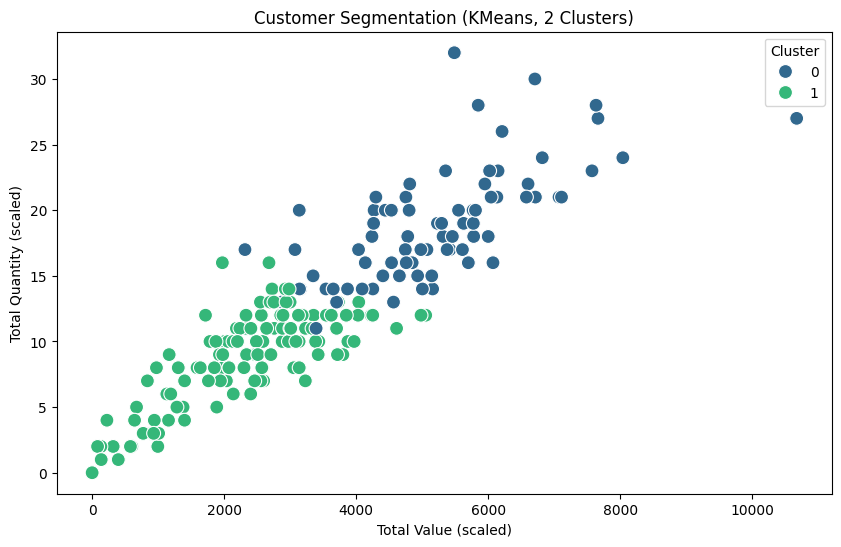

In [16]:
# Visualization of clusters (2D)
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data["TotalValue"], y=data["TotalQuantity"], hue=data["Cluster"], palette="viridis", s=100
)
plt.title(f"Customer Segmentation (KMeans, {optimal_k} Clusters)")
plt.xlabel("Total Value (scaled)")
plt.ylabel("Total Quantity (scaled)")
plt.legend(title="Cluster")
plt.show()



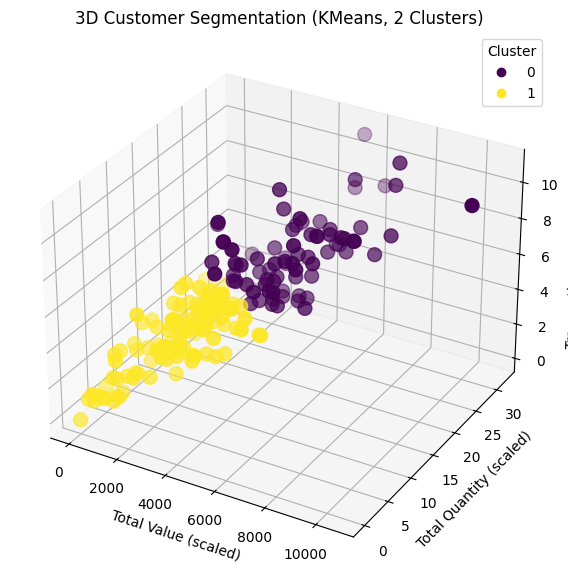

In [17]:
# Optional 3D visualization
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(
    data["TotalValue"], data["TotalQuantity"], data["TransactionCount"],
    c=data["Cluster"], cmap="viridis", s=100
)
ax.set_title(f"3D Customer Segmentation (KMeans, {optimal_k} Clusters)")
ax.set_xlabel("Total Value (scaled)")
ax.set_ylabel("Total Quantity (scaled)")
ax.set_zlabel("Transaction Count (scaled)")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()



In [18]:
# Output clustering metrics
print(f"Final Davies-Bouldin Index (DB Index): {optimal_db_index:.4f}")
print(f"Final Silhouette Score: {optimal_silhouette:.4f}")



Final Davies-Bouldin Index (DB Index): 0.9329
Final Silhouette Score: 0.3999


In [19]:
# Save results to CSV
data.to_csv("Customer_Segmentation_FineTuned.csv", index=False)
print("Customer segmentation results saved to Customer_Segmentation_FineTuned.csv.")


Customer segmentation results saved to Customer_Segmentation_FineTuned.csv.
